In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install opencv-python opencv-python-headless
pip install cvzone
pip install ultralytics
pip install facenet-pytorch
pip install torch torchvision
pip install numpy
pip install pillow


In [19]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")



In [20]:
boat_data = "/kaggle/input/boat-types-recognition/boat-types-recognition"

# Custom Dataset definition

In [21]:
class BoatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



# Loading images and labels

In [22]:
def load_dataset(root_dir):
    classes = os.listdir(root_dir)
    images = []
    labels = []

    for idx, boats_type in tqdm(enumerate(classes), total=len(classes)):
        boat_dir = os.path.join(root_dir, boats_type)
        for img_name in os.listdir(boat_dir):
            img_path = os.path.join(boat_dir, img_name)
            images.append(img_path)
            labels.append(idx)

    return images, labels, classes

In [23]:
images, labels, classes = load_dataset(boat_data)
df = pd.DataFrame({"images": images, "labels": labels})
df.tail()


100%|██████████| 9/9 [00:00<00:00, 911.74it/s]


images  labels
1457  /kaggle/input/boat-types-recognition/boat-type...       8
1458  /kaggle/input/boat-types-recognition/boat-type...       8
1459  /kaggle/input/boat-types-recognition/boat-type...       8
1460  /kaggle/input/boat-types-recognition/boat-type...       8
1461  /kaggle/input/boat-types-recognition/boat-type...       8

# Train, Validation, Test split

In [24]:
train_indices, val_indices, test_indices = [], [], []

# Dividir os dados em treinamento, validação e teste
train_indices, test_val_indices = train_test_split(range(len(images)), test_size=0.2, stratify=labels)
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, stratify=[labels[i] for i in test_val_indices])

# Criar listas para imagens e rótulos
def get_images_labels(indices):
    return [images[i] for i in indices], [labels[i] for i in indices]

train_images, train_labels = get_images_labels(train_indices)
val_images, val_labels = get_images_labels(val_indices)
test_images, test_labels = get_images_labels(test_indices)


In [25]:
import os
import shutil

# Caminho para o diretório onde os dados serão armazenados
base_dir = 'boat_data'

# Nomes dos subdiretórios
subdirs = ['train', 'val', 'test']

# Função para criar as pastas
def create_folders(base_dir, subdirs):
    for subdir in subdirs:
        path = os.path.join(base_dir, subdir)
        if not os.path.exists(path):
            os.makedirs(path)

# Função para salvar as imagens e rótulos nas pastas apropriadas
def save_images_to_folder(images, labels, base_dir, subdir):
    for i, (image, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(base_dir, subdir, str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        image_path = os.path.join(label_dir, f'image_{i}.jpg')
        # Supondo que 'image' seja um caminho para a imagem ou um array de imagem
        # Se 'image' for um array de imagem, use cv2.imwrite ou similar para salvar a imagem
        if isinstance(image, str):
            shutil.copy(image, image_path)
        else:
            # Supondo que você use OpenCV para salvar imagens
            import cv2
            cv2.imwrite(image_path, image)

# Criar as pastas
create_folders(base_dir, subdirs)

# Salvar as imagens e rótulos nas pastas apropriadas
save_images_to_folder(train_images, train_labels, base_dir, 'train')
save_images_to_folder(val_images, val_labels, base_dir, 'val')
save_images_to_folder(test_images, test_labels, base_dir, 'test')


In [26]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [27]:
train_dataset = BoatDataset(images=train_images, labels=train_labels, transform=train_transforms)
val_dataset = BoatDataset(images=val_images, labels=val_labels, transform=eval_transforms)
test_dataset = BoatDataset(images=test_images, labels=test_labels, transform=eval_transforms)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [29]:
class BoatModel(nn.Module):
    def __init__(self, num_classes):
        super(BoatModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(0.25),  # Dropout adicionado

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(0.25),  # Dropout adicionado

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(0.25),  # Dropout adicionado

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(0.25),  # Dropout adicionado

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(0.25)  # Dropout adicionado
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(1024 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [30]:
class BoatModel(nn.Module):
    def __init__(self, num_classes):
        super(BoatModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.load_state_dict(torch.load('/kaggle/input/resnet180/resnet18-f37072fd.pth'))  # Substitua pelo caminho do seu modelo baixado
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BoatModel(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)




In [32]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device=device):
    model.train()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0.0
        total = 0.0
        
        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        val_running_loss = 0.0
        val_correct = 0.0
        val_total = 0.0
        
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in tqdm(valid_loader, desc=f'Validation {epoch+1}/{num_epochs}'):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)
        
        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_epoch_accuracy = val_correct / val_total * 100
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')
        
    torch.save(model.state_dict(), 'boat_model_res.pth')
    print('Finished Training')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [33]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30, device=device)

Validation 1/30: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Training Loss: 1.6055, Training Accuracy: 49.44%
Validation Loss: 0.9980, Validation Accuracy: 74.66%


Validation 2/30: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Training Loss: 0.8694, Training Accuracy: 75.79%
Validation Loss: 0.6829, Validation Accuracy: 79.45%


Validation 3/30: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Training Loss: 0.6666, Training Accuracy: 81.35%
Validation Loss: 0.6255, Validation Accuracy: 81.51%


Validation 4/30: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Training Loss: 0.5849, Training Accuracy: 84.00%
Validation Loss: 0.5745, Validation Accuracy: 80.82%


Validation 5/30: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Training Loss: 0.5338, Training Accuracy: 84.94%
Validation Loss: 0.5282, Validation Accuracy: 84.25%


Validation 6/30: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Training Loss: 0.4668, Training Accuracy: 87.68%
Validation Loss: 0.5333, Validation Accuracy: 85.62%


Validation 7/30: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Training Loss: 0.4142, Training Accuracy: 88.20%
Validation Loss: 0.5162, Validation Accuracy: 85.62%


Validation 8/30: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Training Loss: 0.3558, Training Accuracy: 90.08%
Validation Loss: 0.5116, Validation Accuracy: 86.99%


Validation 9/30: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Training Loss: 0.3354, Training Accuracy: 91.10%
Validation Loss: 0.5388, Validation Accuracy: 82.88%


Validation 10/30: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Training Loss: 0.3265, Training Accuracy: 91.10%
Validation Loss: 0.4712, Validation Accuracy: 86.99%


Validation 11/30: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Training Loss: 0.3260, Training Accuracy: 90.85%
Validation Loss: 0.4752, Validation Accuracy: 85.62%


Validation 12/30: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Training Loss: 0.3047, Training Accuracy: 90.59%
Validation Loss: 0.4894, Validation Accuracy: 84.25%


Validation 13/30: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Training Loss: 0.2897, Training Accuracy: 91.70%
Validation Loss: 0.4847, Validation Accuracy: 86.30%


Validation 14/30: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Training Loss: 0.2848, Training Accuracy: 92.56%
Validation Loss: 0.4814, Validation Accuracy: 86.99%


Validation 15/30: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Training Loss: 0.2399, Training Accuracy: 93.58%
Validation Loss: 0.5375, Validation Accuracy: 85.62%


Validation 16/30: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Training Loss: 0.2259, Training Accuracy: 94.53%
Validation Loss: 0.4704, Validation Accuracy: 86.99%


Validation 17/30: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Training Loss: 0.2301, Training Accuracy: 93.93%
Validation Loss: 0.4881, Validation Accuracy: 84.93%


Validation 18/30: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Training Loss: 0.2123, Training Accuracy: 95.04%
Validation Loss: 0.4985, Validation Accuracy: 85.62%


Validation 19/30: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Training Loss: 0.2140, Training Accuracy: 93.58%
Validation Loss: 0.5751, Validation Accuracy: 84.25%


Validation 20/30: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Training Loss: 0.2168, Training Accuracy: 94.10%
Validation Loss: 0.4544, Validation Accuracy: 88.36%


Validation 21/30: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Training Loss: 0.1821, Training Accuracy: 94.95%
Validation Loss: 0.5619, Validation Accuracy: 86.99%


Validation 22/30: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Training Loss: 0.1735, Training Accuracy: 95.38%
Validation Loss: 0.4925, Validation Accuracy: 88.36%


Validation 23/30: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Training Loss: 0.1590, Training Accuracy: 95.81%
Validation Loss: 0.4684, Validation Accuracy: 87.67%


Validation 24/30: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Training Loss: 0.2088, Training Accuracy: 95.04%
Validation Loss: 0.4351, Validation Accuracy: 88.36%


Validation 25/30: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Training Loss: 0.1666, Training Accuracy: 95.64%
Validation Loss: 0.4160, Validation Accuracy: 90.41%


Validation 26/30: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Training Loss: 0.1646, Training Accuracy: 95.38%
Validation Loss: 0.4931, Validation Accuracy: 88.36%


Validation 27/30: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Training Loss: 0.1714, Training Accuracy: 95.21%
Validation Loss: 0.5847, Validation Accuracy: 84.25%


Validation 28/30: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Training Loss: 0.1980, Training Accuracy: 94.70%
Validation Loss: 0.5328, Validation Accuracy: 86.30%


Validation 29/30: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Training Loss: 0.1461, Training Accuracy: 96.15%
Validation Loss: 0.5353, Validation Accuracy: 88.36%


Validation 30/30: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

Training Loss: 0.1459, Training Accuracy: 96.24%
Validation Loss: 0.4860, Validation Accuracy: 87.67%
Finished Training


In [34]:
def evaluate_model(model, test_loader, criterion, device=device):
    model.eval()
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / total * 100

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device=device)


Testing: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

Test Loss: 0.5290, Test Accuracy: 85.03%


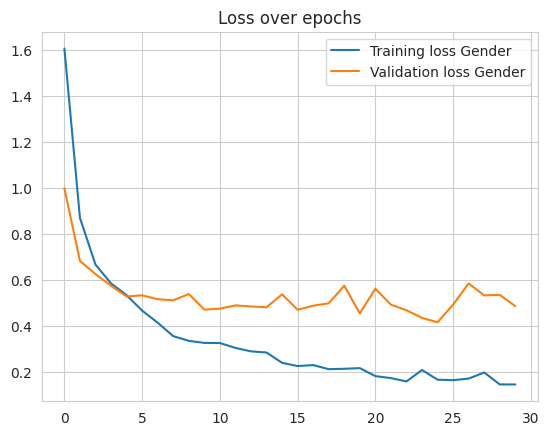

In [35]:
plt.plot(train_losses, label='Training loss Gender')
plt.plot(val_losses, label='Validation loss Gender')
plt.legend()
plt.title("Loss over epochs")
plt.show()

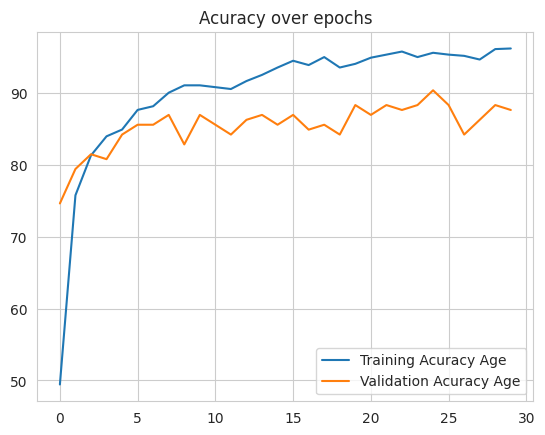

In [36]:
plt.plot(train_accuracies, label='Training Acuracy Age')
plt.plot(val_accuracies, label='Validation Acuracy Age')
plt.legend()
plt.title("Acuracy over epochs")
plt.show()

In [39]:
import matplotlib.pyplot as plt

def test_and_visualize_predictions(model, test_loader, classes, device, max_images=25):
    # Carrega o estado do modelo treinado
    model.load_state_dict(torch.load('boat_model_res.pth', map_location=device))
    model.to(device)
    model.eval()

    # Contador para limitar a 25 imagens
    count = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Passar as imagens pelo modelo
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if count >= max_images:
                    break
                
                # Visualiza a imagem e a previsão
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 255).astype(np.uint8)  # Reverter normalização
                
                true_label = classes[labels[i].item()]
                predicted_label = classes[predicted[i].item()]
                
                plt.figure(figsize=(4, 4))
                plt.imshow(image)
                plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
                plt.axis('off')
                plt.show()
                
                count += 1
                
            if count >= max_images:
                break

# Uso da função (exemplo)
# test_and_visualize_predictions(model, test_loader, classes, device)


  0%|          | 0/3 [00:00<?, ?it/s]

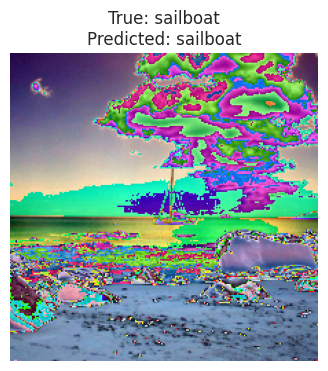

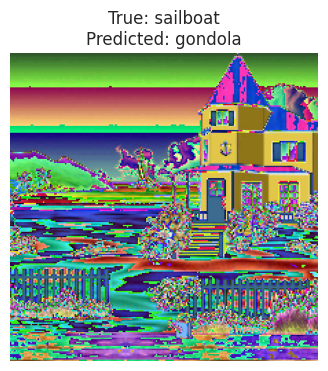

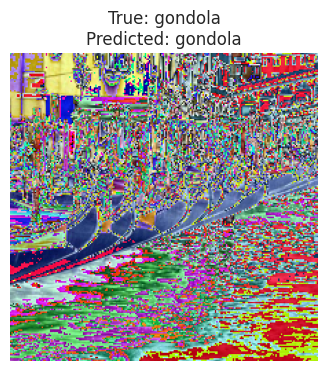

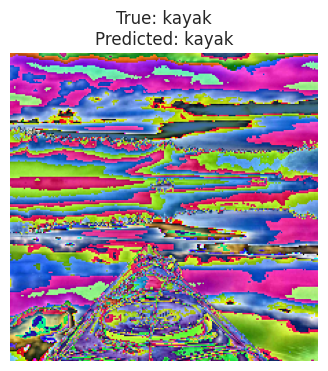

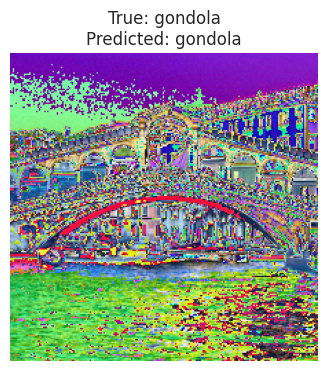

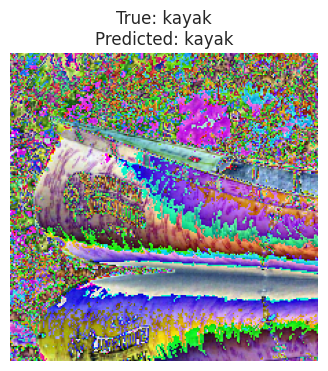

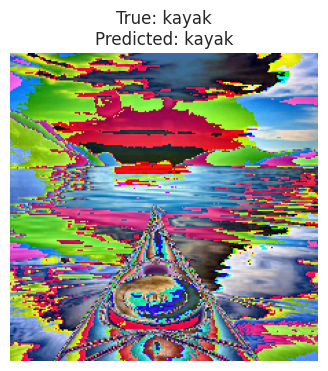

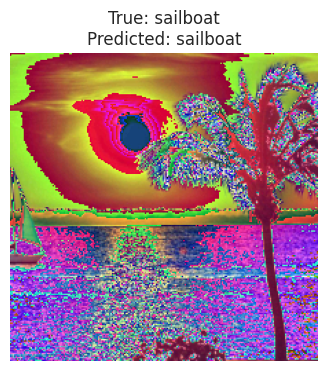

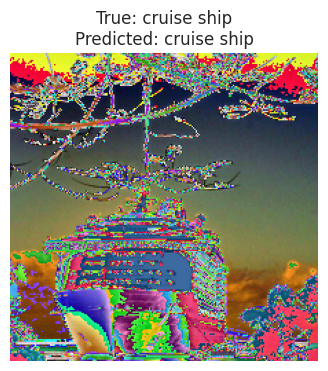

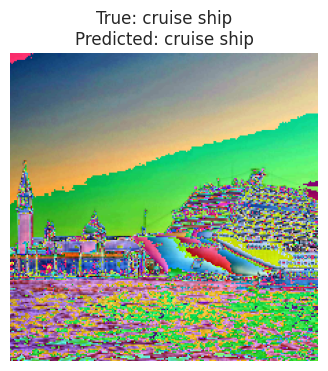

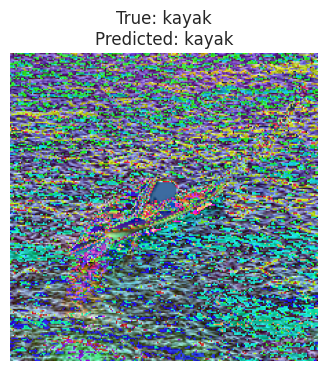

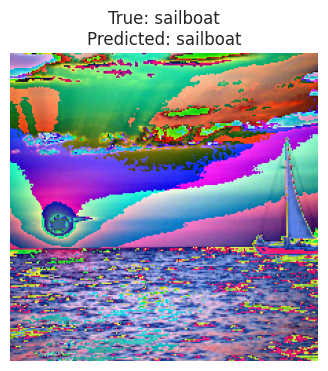

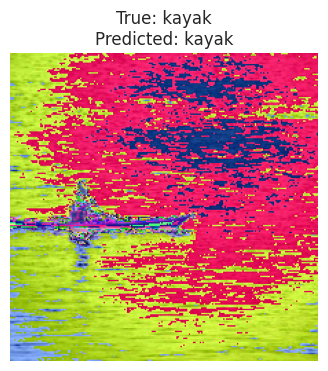

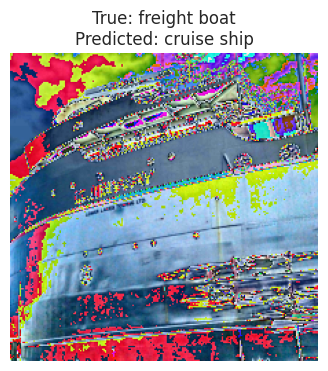

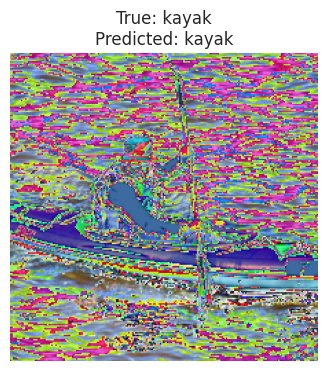

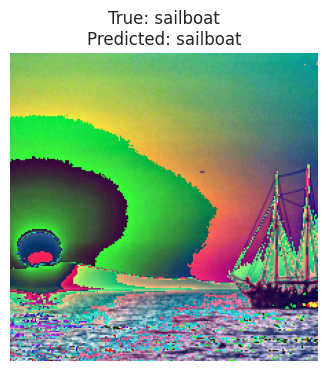

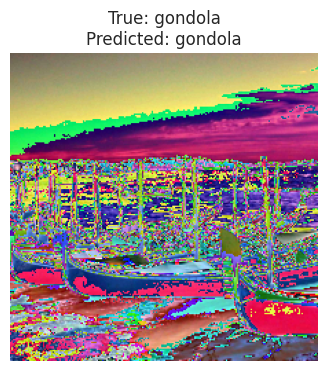

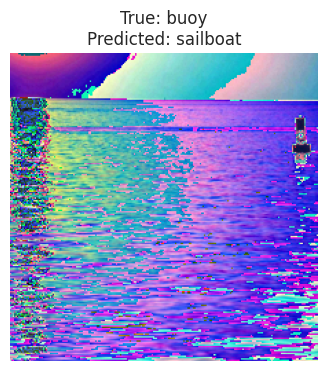

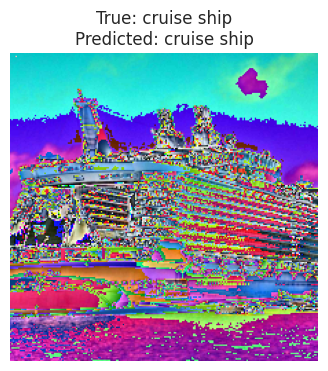

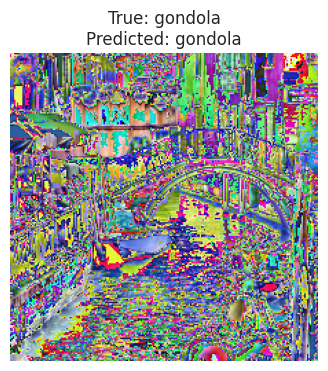

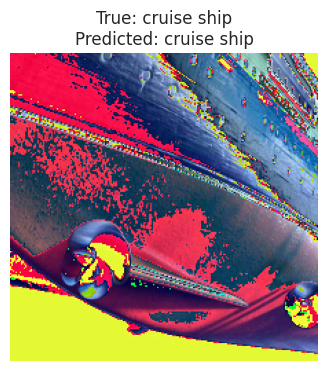

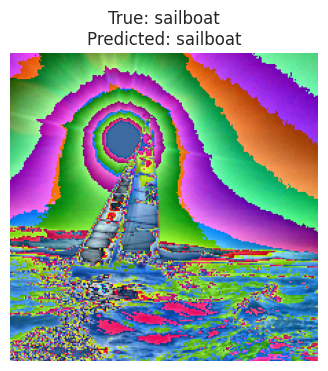

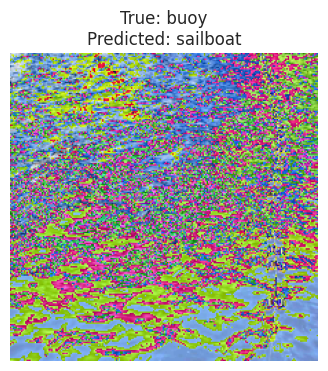

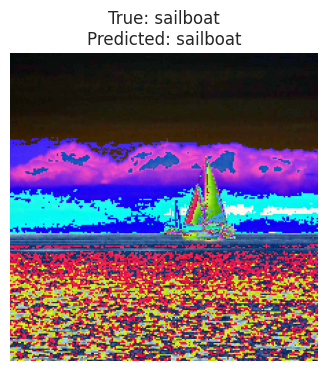

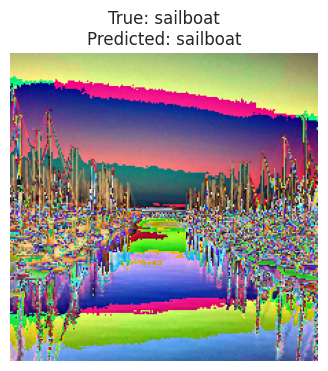

  0%|          | 0/3 [00:07<?, ?it/s]


In [40]:
# Supondo que `model`, `test_loader`, `classes`, e `device` estejam definidos
test_and_visualize_predictions(model, test_loader, classes, device)


In [35]:
# Número de épocas de treinamento
num_epochs = 40

# Colocar o modelo em modo de treinamento
model.train()
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0.0
    total =0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zerar os gradientes
        optimizer.zero_grad()
        
        # Passo forward
        outputs = model(images)
        
        # Calcular a perda
        loss = criterion(outputs.squeeze(), labels)
        
        # Passo backward
        loss.backward()
        
        # Atualizar parâmetros
        optimizer.step()
        
        # Estatísticas
        running_loss += loss.item() * images.size(0)
        
        # Accuracy
        _, predicted = torch.max(outputs.squeeze(), 1)
        correct += (predicted == labels.data).sum().item()
        total += labels.size(0)
    # Calcular média da perda
    epoch_loss = running_loss / len(train_loader.dataset)
    
    epoch_accs = correct/total*100
    
    losses.append(epoch_loss)
    accs.append(epoch_accs)
    torch.save(model.state_dict(), 'boat_model.pth')
    # Imprimir estatísticas do treinamento
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accs:.4f}')
    
print('Finished Training')


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch [1/40], Loss: 0.5396, Accuracy: 81.9504


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch [2/40], Loss: 0.5148, Accuracy: 82.5492


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch [3/40], Loss: 0.5293, Accuracy: 81.7793


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch [4/40], Loss: 0.4745, Accuracy: 83.5757


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch [5/40], Loss: 0.3952, Accuracy: 87.8529


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch [6/40], Loss: 0.3704, Accuracy: 86.7408


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch [7/40], Loss: 0.4000, Accuracy: 86.9119


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch [8/40], Loss: 0.3498, Accuracy: 87.7673


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch [9/40], Loss: 0.3193, Accuracy: 88.7938


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch [10/40], Loss: 0.2587, Accuracy: 90.7613


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch [11/40], Loss: 0.2976, Accuracy: 89.9914


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch [12/40], Loss: 0.2982, Accuracy: 90.5902


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch [13/40], Loss: 0.2880, Accuracy: 90.1625


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch [14/40], Loss: 0.2446, Accuracy: 91.7879


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch [15/40], Loss: 0.2173, Accuracy: 93.3276


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch [16/40], Loss: 0.2037, Accuracy: 93.8409


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch [17/40], Loss: 0.1728, Accuracy: 94.3541


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch [18/40], Loss: 0.1885, Accuracy: 93.4987


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch [19/40], Loss: 0.1791, Accuracy: 93.6698


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch [20/40], Loss: 0.1776, Accuracy: 94.3541


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch [21/40], Loss: 0.1533, Accuracy: 95.1240


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch [22/40], Loss: 0.1684, Accuracy: 94.5252


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch [23/40], Loss: 0.1222, Accuracy: 96.3216


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch [24/40], Loss: 0.1592, Accuracy: 94.8674


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch [25/40], Loss: 0.1287, Accuracy: 95.5518


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch [26/40], Loss: 0.1749, Accuracy: 94.6108


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch [27/40], Loss: 0.1141, Accuracy: 96.3216


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch [28/40], Loss: 0.1195, Accuracy: 96.2361


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch [29/40], Loss: 0.1114, Accuracy: 97.1771


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch [30/40], Loss: 0.1102, Accuracy: 96.4072


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch [31/40], Loss: 0.1749, Accuracy: 94.5252


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch [32/40], Loss: 0.1510, Accuracy: 94.4397


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch [33/40], Loss: 0.1285, Accuracy: 95.8939


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch [34/40], Loss: 0.1082, Accuracy: 95.8939


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch [35/40], Loss: 0.1097, Accuracy: 96.4072


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch [36/40], Loss: 0.0960, Accuracy: 96.6638


100%|██████████| 37/37 [00:10<00:00,  3.42it/s]


Epoch [37/40], Loss: 0.0758, Accuracy: 97.0915


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch [38/40], Loss: 0.0956, Accuracy: 97.0060


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch [39/40], Loss: 0.1033, Accuracy: 97.0060


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch [40/40], Loss: 0.0978, Accuracy: 97.2626
Finished Training


In [40]:
# Colocar o modelo em modo de avaliação
model.eval()

total_val_loss = 0.0
correct_val_predictions = 0
total_val_predictions = 0

with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item() * images.size(0)
        
        # Calcular a acurácia
        _, predicted = torch.max(outputs, 1)
        correct_val_predictions += (predicted == labels).sum().item()
        total_val_predictions += labels.size(0)

# Média da perda e da acurácia para o conjunto de validação
val_loss = total_val_loss / len(valid_loader.dataset)
val_accuracy = correct_val_predictions / total_val_predictions * 100

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

Validation Loss: 1.8546, Validation Accuracy: 60.27%
